# GAN Modell zur Generierung von synthetischen Daten


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [2]:
# Beispiel Daten laden
data = pd.read_csv('./../Data/preprocessed_df_v2.csv') # Pfad zu Ihren Daten

print(data.head())

# Auffüllen von NaN-Werten mit dem Mittelwert der jeweiligen Spalte
data = data.fillna(data.mean())

# Überprüfen auf NaN-Werte in den Daten
assert not np.any(np.isnan(data)), "Daten enthalten NaN-Werte"


   participant_id  test_id  test_duration  mental  physical  temporal  \
0               1        1      33.643950      10         5        15   
1               1        2      28.484322      50        30        25   
2               1        3      71.423823     100        10        75   
3               1        4      38.163442      60        15        45   
4               2        1      41.748047      20        10        20   

   performance  effort  frustration  mean  ...  blinkrate  fixationrate  \
0           25      25           10  15.0  ...   0.059446      0.295946   
1           50      15           25  32.5  ...   0.000000      0.175533   
2           80      90           20  62.5  ...   0.196013      0.196018   
3           50      20           25  35.8  ...   0.052406      0.288263   
4           10      20           15  15.8  ...   0.047906      0.143727   

   blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  fixationrate_rel_pct  \
0       0.000000           0.00

In [3]:
# Daten skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# GAN-Parameter
latent_dim = 100
data_dim = data_scaled.shape[1]

## GAN Definition

In [4]:
# Generator-Modell
def build_generator(latent_dim, data_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(latent_dim,)))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(data_dim, activation='tanh'))
    return model

# Diskriminator-Modell
def build_discriminator(data_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(data_dim,)))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# GAN-Modell
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [5]:
# Modelle erstellen

learning_rate_discriminator = 0.00005
learning_rate_generator = 0.0001

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer=Adam(learning_rate_discriminator, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate_generator, 0.5), loss='binary_crossentropy')

# Trainingsdaten
real = data_scaled
real_labels = np.ones((real.shape[0], 1))
fake_labels = np.zeros((real.shape[0], 1))

2024-06-13 18:47:02.134650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-13 18:47:02.134673: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-13 18:47:02.134684: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-13 18:47:02.134852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 18:47:02.134865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training

In [6]:
# GAN-Training
epochs = 10
batch_size = 32

d_losses = []
g_losses = []

for epoch in range(epochs):
    # Zufällige Samples von realen Daten
    idx = np.random.randint(0, real.shape[0], batch_size)
    real_samples = real[idx]
    
    # Zufälliges Rauschen und Fake-Daten generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)
    
    # Diskriminator trainieren
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels[:batch_size])
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels[:batch_size])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # GAN trainieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels[:batch_size])
    
    # Verluste speichern
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    # Fortschritt ausgeben
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

print("Training abgeschlossen!")
print(f"{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2024-06-13 18:47:02.424040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/hennerbendig/anaconda3/envs/tf_311/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6803096532821655, acc.: 77.34375%] [G loss: [array(0.68312067, dtype=float32), array(0.68312067, dtype=float32), array(0.734375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training abgeschlossen!
10 [D loss: 0.697899580001831, acc.: 45.22203803062439%] [G loss: [array(0.69937193, dtype=float32), array(0.69937193, dtype=float32), array(0.440625, dtype=float32)]]


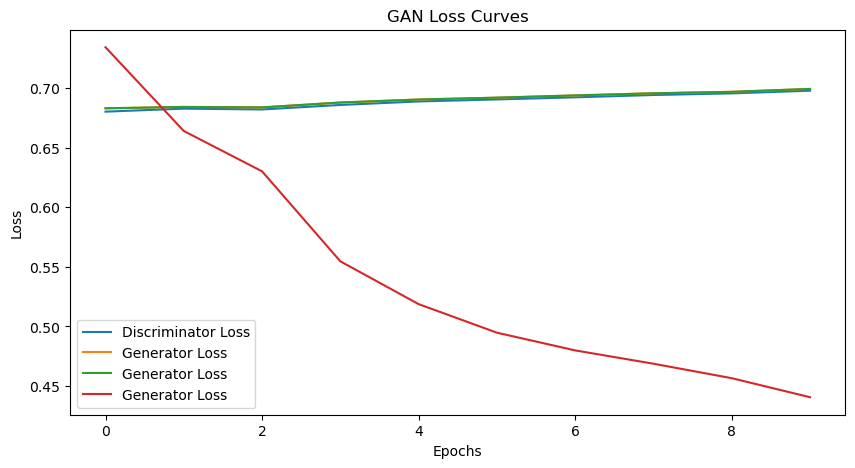

In [7]:
# Verlustkurven plotten
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

## Daten generieren

In [8]:
# Generieren von zusätzlichen Datenpunkten nach dem Training
num_additional_points = 1000
noise = np.random.normal(0, 1, (num_additional_points, latent_dim))
synthetic_data_scaled = generator.predict(noise)

# Die generierten Daten zurückskalieren auf den ursprünglichen Wertebereich
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)

# Die generierten Daten mit den Originaldaten kombinieren
augmented_data = np.vstack((data, synthetic_data))

# Optional: Konvertieren Sie die Daten in ein TensorFlow-Dataset
dataset = tf.data.Dataset.from_tensor_slices(augmented_data)

print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data.shape)
print("Augmented Data Shape:", augmented_data.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Original Data Shape: (188, 22)
Synthetic Data Shape: (1000, 22)
Augmented Data Shape: (1188, 22)


In [9]:
# Ausgewählte Datenpunkte plotten
synthetic_data = pd.DataFrame(synthetic_data, columns=data.columns)
print("Synthetic Data")
print(synthetic_data[:5])

Synthetic Data
   participant_id   test_id  test_duration     mental   physical   temporal  \
0       18.604145  1.980455    5192.609863  48.277180  69.355309  67.657829   
1       26.610748  2.283609    5397.325195  33.910423  67.354424  83.551407   
2       12.054751  2.045084    6203.113770  48.705391  69.932304  81.667206   
3       16.320562  2.099850    5127.345703  20.410112  41.494133  70.428001   
4       19.988539  2.168063    4151.083008  51.340275  55.324356  73.557159   

   performance     effort  frustration       mean  ...  blinkrate  \
0    34.416561  25.330894    55.587761  51.589340  ...   0.372338   
1    39.801422  16.528912    60.359955  54.777393  ...   0.262484   
2    68.163948  17.746389    28.263319  60.628716  ...   0.232626   
3    41.961208  23.008657    42.368271  45.790707  ...   0.160717   
4    41.581596  34.635506    43.945049  50.468540  ...   0.251374   

   fixationrate  blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  \
0      0.243377       0.